# Project Milestone 4: Preliminary Results

## Imports 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn import preprocessing, svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

from py.classifiers import classify

## Feature extraction 

Load the data.

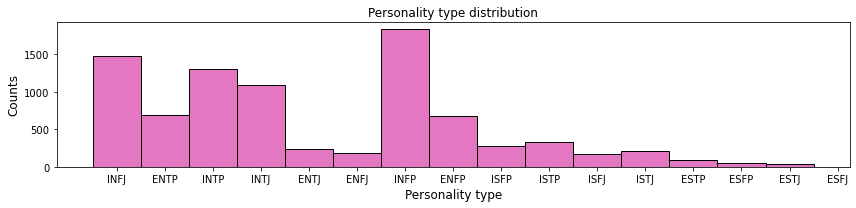

In [4]:
data = pd.read_csv('./data/mbti_1.csv')

fig, ax = plt.subplots(tight_layout=True)
ax = data['type'].hist(figsize=(12, 3), bins=np.arange(16)-0.5, 
                       ec='k', color='tab:pink', grid=False, ax=ax)
ax.set_xlabel('Personality type', fontsize='large')
ax.set_ylabel('Counts', fontsize='large')
ax.set_title('Personality type distribution', fontsize='large')
plt.savefig('figures/personality_type_dist.png', dpi=300)

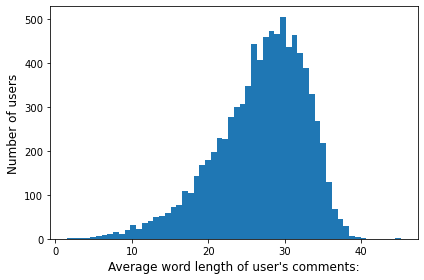

In [5]:
mean_comment_lengths = []
for i in range(data.shape[0]):
    comments = data.loc[i, 'posts'].split('|||')
    mean_coment_length = np.mean([len(comment.split(' ')) for comment in comments])
    mean_comment_lengths.append(mean_coment_length)
    
fig, ax = plt.subplots(tight_layout=True)
ax.hist(mean_comment_lengths, bins='auto')
ax.set_ylabel('Number of users', fontsize='large')
ax.set_xlabel("Average word length of user's comments:", fontsize='large')
plt.savefig('figures/comment_length_dist.png', dpi=300)

Change to integer feature labels.

In [6]:
data = data.replace({c: i for i, c in enumerate(pd.unique(data['type']))})
data.head()

,type,posts
0,0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,1,'I'm finding the lack of me in these posts ver...
2,2,'Good one _____ https://www.youtube.com/wat...
3,3,"'Dear INTP, I enjoyed our conversation the o..."
4,4,'You're fired.|||That's another silly misconce...


Create feature matrix of raw word frequencies.

In [7]:
vectorizer = CountVectorizer(input='content')
X = vectorizer.fit_transform(list(data['posts']))
y = data['type'].values

print('n_classes =', X.shape[0])
print('n_features =', X.shape[1])

n_classes = 8675
n_features = 145412


View the most frequent words.

In [8]:
word_freq_list = list(vectorizer.vocabulary_.items())
sorted_word_freq_list = sorted(word_freq_list, key=lambda x: x[1], reverse=True)

sorted_word_freq_list[:10]

[('ﾟﾟ', 145411),
 ('ﾟдﾟщ', 145410),
 ('ﾉﾟ', 145409),
 ('ﾉﾞ', 145408),
 ('ﾉｼ', 145407),
 ('ﾉωﾉ', 145406),
 ('ｗｈｙu3000ｉｓu3000ａｎｙｏｎｅu3000ｓｔｉｌｌu3000ｄｉｓｃｕｓｓｉｎｇu3000ｔｈｉｓ', 145405),
 ('ｖａｐｏｒｗａｖｅ', 145404),
 ('ｔｒｕｍｐu3000ｉｓu3000ａｎu3000ｅｓｔｐ', 145403),
 ('ｓｏ', 145402)]

Split into testing and training.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Training samples: {}'.format(len(y_train)))
print('Testing samples: {}'.format(len(y_test)))

Training samples: 6940
Testing samples: 1735


### Feature selection
See https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection. For example, we could use `mutual_info_classif` with `SelectKBest` to keep the $K$ best features according to their mutual information score. Or could do something else for now like PCA.

Select a dimensionality reduction technique below. Run only that section of cells. Then split into testing/training sets before running classification.

#### Mutual Information

In [10]:
m_info_scores = mutual_info_classif(X_train, y_train)
m_info_scores

array([4.63581620e-03, 4.02814192e-03, 5.26090599e-04, ...,
       2.98372438e-16, 2.77634655e-04, 2.94722181e-04])

The mutual info scores are relatively very low. There are only 6 features with a score greater than 0.1, 381 features with a score greater than 0.01, and 19037 features with a score greater than 0.001. The last threshold represents about 13% of the features, so I think that's a good starting point.

In [11]:
k_num = np.count_nonzero(m_info_scores > 0.001)
print(k_num)
X_new = SelectKBest(chi2, k=k_num).fit_transform(X, y)
print(X_new.shape)

19037
(8675, 19037)


#### PCA / Truncated Singular Value Decomp
X matrix is sparse but dense so PCA and SparsePCA does not work, needed to use TruncatedSVD

Found that 500 features explains above 86.7% of the variance. We can easily automate this to find some preferred error rate. 

In [12]:
pca = TruncatedSVD(n_components=500, n_iter=10, random_state=42)
X_new = pca.fit_transform(X, y)
print(X_new.shape)
print(pca.explained_variance_ratio_.sum())

(8675, 500)
0.8670950171056562


Re-split into testing and training after reducing dimensionality.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)
print('Training samples: {}'.format(len(y_train)))
print('Testing samples: {}'.format(len(y_test)))

Training samples: 6940
Testing samples: 1735


## Classification

Random guessing.

In [14]:
y_pred = np.random.randint(0, 16, size=y_test.shape)
print('Accuracy = {:.2f}'.format(accuracy_score(y_test, y_pred)))

Accuracy = 0.06


[0 7 1 ... 0 6 3]
[ 2  3  2 ...  0 11  2]


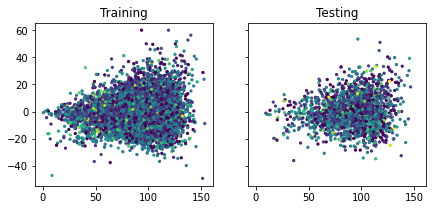

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=True, sharex=True)
for ax, X, y, title in zip(axes, (X_train, X_test), (y_train, y_test), ('Training', 'Testing')):
    print(y)
    ax.scatter(X[:, 0], X[:, 1], s=5, c=y)
    ax.set_title(title)

In [ ]:

fig, axes = plt.subplots(1, 6, sharey=True, sharex=True, figsize=(20, 3))



/Users/clifton/Dropbox/Grad_school/cosc522/team_project/playground/py/classifiers.py:210: RuntimeWarning: divide by zero encountered in log
  g[c] = -mdist2 / 2 - np.log(np.linalg.det(self.covs[c])) / 2 + np.log(self.P[c] + 0.000001)


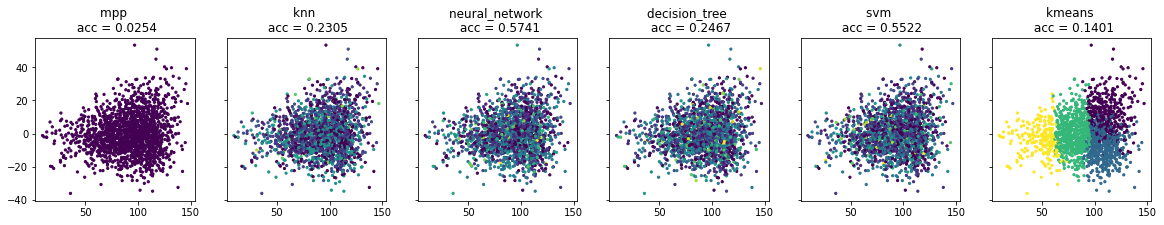

In [44]:
method_kwargs_list = [
    ('mpp', dict(case=3)), 
    ('knn', dict(n_neighbors=5)),
    ('neural_network', dict()),
    ('decision_tree', dict()),
    ('svm', dict(kernel='linear')),
    ('kmeans', dict(n_clusters=4))
]
plts = len(method_kwargs_list)

fig, axes = plt.subplots(1, plts, sharey=True, sharex=True, figsize=(20, 3))


for (method, kwargs), ax in zip(method_kwargs_list, axes):
    y_pred = classify(X_train, y_train, X_test, method, **kwargs)
    ax.scatter(X_test[:, 0], X_test[:, 1], s=5, c=y_pred[0])
    ax.set_title('{} \n acc = {:.4f}'.format(method, accuracy_score(y_pred[0], y_test)))

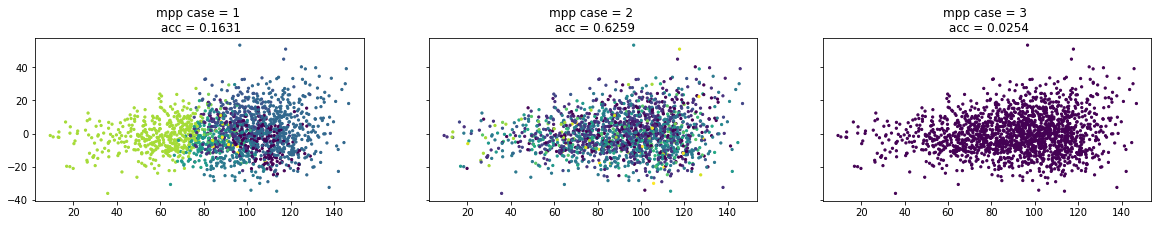

In [54]:
method_kwargs_list = [
    ('mpp', dict(case=1)), 
    ('mpp', dict(case=2)),
    ('mpp', dict(case=3))
]
plts = len(method_kwargs_list)

fig, axes = plt.subplots(1, plts, sharey=True, sharex=True, figsize=(20, 3))

i = 0
for (method, kwargs), ax in zip(method_kwargs_list, axes):
    y_pred = classify(X_train, y_train, X_test, method, **kwargs)
    ax.scatter(X_test[:, 0], X_test[:, 1], s=5, c=y_pred[0])
    ax.set_title('{} case = {} \n acc = {:.4f}'.format(method, method_kwargs_list[i][1]['case'], accuracy_score(y_pred[0], y_test)))
    i += 1

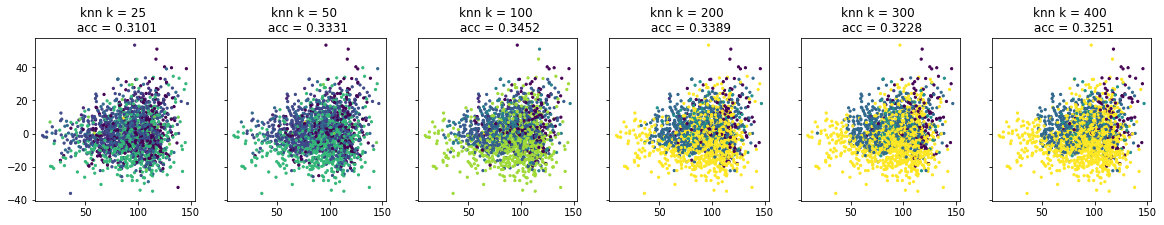

In [56]:
method_kwargs_list = [
    ('knn', dict(n_neighbors=25)),
    ('knn', dict(n_neighbors=50)),
    ('knn', dict(n_neighbors=100)), 
    ('knn', dict(n_neighbors=200)),
    ('knn', dict(n_neighbors=300)),
    ('knn', dict(n_neighbors=400))
]
plts = len(method_kwargs_list)

fig, axes = plt.subplots(1, plts, sharey=True, sharex=True, figsize=(20, 3))

i = 0
for (method, kwargs), ax in zip(method_kwargs_list, axes):
    y_pred = classify(X_train, y_train, X_test, method, **kwargs)
    ax.scatter(X_test[:, 0], X_test[:, 1], s=5, c=y_pred[0])
    ax.set_title('{} k = {} \n acc = {:.4f}'.format(method, method_kwargs_list[i][1]['n_neighbors'], accuracy_score(y_pred[0], y_test)))
    i += 1

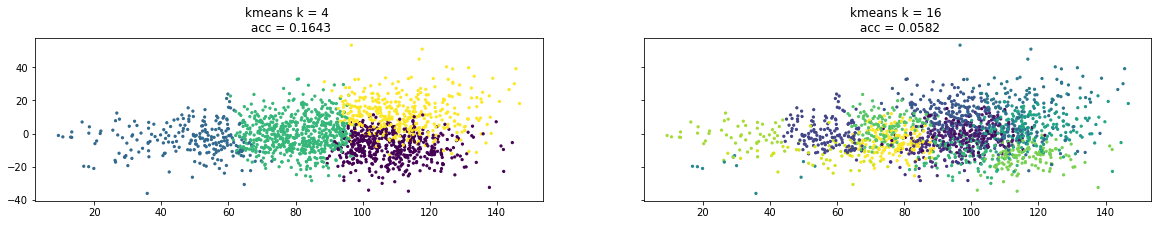

In [58]:
method_kwargs_list = [
    ('kmeans', dict(n_clusters=4)),
    ('kmeans', dict(n_clusters=16))
]

plts = len(method_kwargs_list)

fig, axes = plt.subplots(1, plts, sharey=True, sharex=True, figsize=(20, 3))

i = 0
for (method, kwargs), ax in zip(method_kwargs_list, axes):
    y_pred = classify(X_train, y_train, X_test, method, **kwargs)
    ax.scatter(X_test[:, 0], X_test[:, 1], s=5, c=y_pred[0])
    ax.set_title('{} k = {} \n acc = {:.4f}'.format(method, method_kwargs_list[i][1]['n_clusters'], accuracy_score(y_pred[0], y_test)))
    i += 1

Support vector machine (linear kernel).
I assume we'll get better results ith TF-IDF vectors but do we need that for this step?

In [53]:
method_kwargs_list = [
    ('mpp', dict(case=1)), 
    ('mpp', dict(case=2)),
    ('mpp', dict(case=3))
]

print(method_kwargs_list[1][1]['case'])

2


In [27]:
# clf = svm.LinearSVC()
clf = svm.SVC(kernel='linear', C=1)
clf.fit(X_train, y_train)
y_pred_lin = clf.predict(X_test)

SVM polynomial kernel

In [26]:
clf = svm.SVC(kernel='poly', C=1, gamma='auto')
clf.fit(X_train, y_train)
y_pred_pol = clf.predict(X_test)

## Performance evalutation
I suppose we should use $k$-fold cross validation.

Accuracy and cross validation scores vary across runs.
Comparison of linear and polynmomial kernels may not be valid
for these singular run results.

In [18]:
print('Accuracy = {:.2f}'.format(accuracy_score(y_test, y_pred_lin)))

Accuracy = 0.55


In [ ]:
print('Accuracy = {:.2f}'.format(accuracy_score(y_test, y_pred_pol)))

$k$-fold cross validation SVM linear kernel

In [25]:
clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, X_train, y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.55 (+/- 0.02)


$k$-fold cross validation ploynomial kernel

In [24]:
scores = cross_val_score(clf, X_train, y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.47 (+/- 0.04)
